# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [26]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [27]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [28]:
def P1(num_examples):
### STUDENT START ###
    for i in range(0, num_examples):
        print "*"*80
        print "The message of example %d:\n%s" %(i+1, train_data[i])
        print "\n"
        print "The label of example %d: %s" %(i+1, newsgroups_train.target_names[train_labels[i]])
        print "*"*80
        print "\n"
### STUDENT END ###
P1(5)

********************************************************************************
The message of example 1:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


The label of example 1: comp.graphics
********************************************************************************


********************************************************************************
The message of example 2:


Seems to be, barring evidence to the contrary, that 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [29]:
def P2():
### STUDENT START ###
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    
    print("Part 2.a")
    print "*"*80
    print "The size of the covabulary is: %d" %X_train.shape[1]
    print "The average number of non-zero features per example is: %.3f" %(float(X_train.nnz)/X_train.shape[0])
    print "The fraction of the entries in the matrix are non-zero is: about %.4f" %(float(X_train.nnz)/(X_train.shape[0] * X_train.shape[1]) )
    print "*"*80 + "\n"

    print("Part 2.b")
    print "*"*80
    print "The 0th feature strings is: %s" %vectorizer.get_feature_names()[0]
    print "The last feature strings is: %s" % vectorizer.get_feature_names()[-1]
    print "*"*80 + "\n"

    print("Part 2.c")
    print "*"*80
    words = ["atheism", "graphics", "space", "religion"]
    vectorizer = CountVectorizer(vocabulary = words)
    X_train = vectorizer.fit_transform(train_data)
    print "Now the average number of non-zero features per example is: %.3f" %(float(X_train.nnz)/X_train.shape[0])
    print "*"*80 + "\n"

    print("Part 2.d")
    print "*"*80
    vectorizer = CountVectorizer(ngram_range = (2,3), analyzer = 'char')
    X_train = vectorizer.fit_transform(train_data)
    print "The size of the covabulary with  bigram and trigram character features is: %d" %X_train.shape[1]
    print "*"*80 + "\n"

    print("Part 2.e")
    print "*"*80
    vectorizer = CountVectorizer(min_df = 10)
    X_train = vectorizer.fit_transform(train_data)
    print "The size of the covabulary when min_df = 10 is: %d" %X_train.shape[1]
    print "*"*80 + "\n"

    print("Part 2.f")
    print "*"*80
    vec_train = CountVectorizer()
    vec_dev = CountVectorizer()
    X_train = vec_train.fit_transform(train_data)
    X_dev = vec_dev.fit_transform(dev_data)
    # compute the number of words in the dev data are missing from the train vocabulary
    num_missingwords_dev = len(set(vec_dev.vocabulary_) - set(vec_train.vocabulary_) )
    print num_missingwords_dev
    print len(set(vec_dev.vocabulary_) )
    print X_dev.shape[1]
    print "Faction of words in the dev data are missing from the vocabulary is: %.3f" %(float( num_missingwords_dev)/X_dev.shape[1] )
    print "*"*80 + "\n"
### STUDENT END ###

P2()

Part 2.a
********************************************************************************
The size of the covabulary is: 26879
The average number of non-zero features per example is: 96.706
The fraction of the entries in the matrix are non-zero is: about 0.0036
********************************************************************************

Part 2.b
********************************************************************************
The 0th feature strings is: 00
The last feature strings is: zyxel
********************************************************************************

Part 2.c
********************************************************************************
Now the average number of non-zero features per example is: 0.268
********************************************************************************

Part 2.d
********************************************************************************
The size of the covabulary with  bigram and trigram character features is: 35478
*********

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [30]:
def P3():
### STUDENT START ###
    # Initiation a class, Learn the vocabulary dictionary and return term-document matrix
    cv =CountVectorizer()
    X_train = cv.fit_transform(train_data)
    X_dev = cv.transform(dev_data)
    
    ######## k nearest neighbors classifier ########
    # To save searching time, I run two rounds of GridSearchCV(classifier, param, scoring='f1_macro') for optimal K. 
    # I first search K in the range of 5 and 200 with a large step (e.g. 5) and then refine the optimal K in the second
    # round of search between 90 and 100 with a small step (e.g. 1)  
    print "*"*80 
    print "*"*14 + "1st round of GridSearchCV for KNN with a large step:" + "*"*14
    print "*"*80
    knn_param = {'n_neighbors': np.arange(5,205,5)}
    knn = KNeighborsClassifier()
    best_param_knn = GridSearchCV(estimator=knn, param_grid=knn_param, scoring='f1_macro')
    best_param_knn.fit(X_train, train_labels)
    optimal_k = best_param_knn.best_params_['n_neighbors']
    print 'The optimal value for k in the first round of GridSearch is %d' %optimal_k
    print '\n'
    
    print "*"*80 
    print "*"*14 + "2nd round of GridSearchCV for KNN with a small step:" + "*"*14
    print "*"*80
    knn_param = {'n_neighbors': np.arange(80,101,1)}
    best_param_knn = GridSearchCV(estimator=knn, param_grid=knn_param, scoring='f1_macro')
    best_param_knn.fit(X_train, train_labels)
    optimal_k = best_param_knn.best_params_['n_neighbors']
    print 'The refined optimal k value in the second round of GridSearch is %d' %optimal_k
    
    # Report the f1 score and model accuracy of the best model with the optimal K
    f1_knn = metrics.f1_score(dev_labels, best_param_knn.best_estimator_.predict(X_dev), average='macro')
    print "With the optimal K = %d, the KNN model's accuracy and f1 score are %.3f and %.3f, respectively." %(optimal_k, best_param_knn.best_score_, f1_knn)
    print '\n'
    
    ######## Multinomial Naive Bayes classifier ########
    # Here I execute two rounds of GridSearchCV again. I first search the optimal alpha within a large range 
    #(between 0.0001 and 1) with a bigger step and then focus on a narrow region in the second GridSearchCV. 
    print "*"*80 
    print "*"*13 + "1st round of GridSearchCV for Multinomial Naive Bayes:" + "*"*13
    print "*"*80
    param_mnb = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]}
    mnb = MultinomialNB()
    best_param_mnb = GridSearchCV(estimator=mnb, param_grid=param_mnb)
    best_param_mnb.fit(X_train, train_labels)
    optimal_alpha = best_param_mnb.best_estimator_.alpha
    print "The optimal value for k in the first round of GridSearch is %.4f" %optimal_alpha
    print '\n'
    
    print "*"*80 
    print "*"*13 + "2nd round of GridSearchCV for Multinomial Naive Bayes:" + "*"*13
    print "*"*80
    param_mnb = {'alpha': np.arange(0.001,0.01,0.001)}
    best_param_mnb = GridSearchCV(estimator=mnb, param_grid=param_mnb)
    best_param_mnb.fit(X_train, train_labels)
    optimal_alpha = best_param_mnb.best_params_['alpha']
    print 'The refined optimal alpha value in the second round of GridSearch is %.4f' %optimal_alpha
    
    # Report the f1 score and model accuracy of the best model with the optimal alpha
    f1_mnb = metrics.f1_score(dev_labels, best_param_mnb.best_estimator_.predict(X_dev), average='macro')
    print "With the optimal alpha = %.4f, the MultinomialNB model's accuracy and f1 score are %.3f and %.3f, respectively." %(optimal_alpha, best_param_mnb.best_score_, f1_mnb)
    print '\n'
    
    ######## logistic regression with regularization ########
    print "*"*80
    print "*"*15 + "1st round of GridSearchCV for logistic regression:" + "*"*15
    print "*"*80
    param_lr_1 = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
    lr = LogisticRegression(penalty='l2')
    best_param_lr = GridSearchCV(estimator=lr, param_grid=param_lr_1)
    best_param_lr.fit(X_train, train_labels)
    optimal_C = best_param_lr.best_params_['C']
    print "The optimal value for C in the first round of GridSearch is %.4f" %optimal_C
    print '\n'
    
    print "*"*80 
    print "*"*15 + "2nd round of GridSearchCV for logistic regression:" + "*"*15
    print "*"*80
    param_lr_2 = {'C': [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]}
    best_param_lr = GridSearchCV(estimator=lr, param_grid=param_lr_2)
    best_param_lr.fit(X_train, train_labels)
    optimal_C = best_param_lr.best_params_['C']
    
    # Report the f1 score and model accuracy of the best model with the optimal C
    f1_lr = metrics.f1_score(dev_labels, best_param_lr.best_estimator_.predict(X_dev), average='macro')
    print "With the optimal C = %.2f, the logistic regression model's accuracy and f1 score are %.3f and %.3f, respectively." %(optimal_C, best_param_lr.best_score_, f1_lr)
    print '\n'
    
    # Explore the relationship between the sum and the value of C using param_lr_1 as the example
    print "Explore the relationship between the sum and various C values:"
    for c in param_lr_1['C']:
        clf = LogisticRegression(C=c, penalty='l2')
        clf.fit(X_train, train_labels)
        predict_dev = clf.predict(X_dev)
        print("When C=%.2f" % c)
        for i in range(0, len(categories)):
            print("The sum of squared weight for Class %d is: %.3f" % (i, np.sum(np.array(clf.coef_[i]) ** 2)))
        print "\n"

 ### STUDENT END ###
P3()

********************************************************************************
**************1st round of GridSearchCV for KNN with a large step:**************
********************************************************************************
The optimal value for k in the first round of GridSearch is 95


********************************************************************************
**************2nd round of GridSearchCV for KNN with a small step:**************
********************************************************************************
The refined optimal k value in the second round of GridSearch is 95
With the optimal K = 95, the KNN model's accuracy and f1 score are 0.412 and 0.438, respectively.


********************************************************************************
*************1st round of GridSearchCV for Multinomial Naive Bayes:*************
********************************************************************************
The optimal value for k in the first r

ANSWER: 
**************************************************************
3.a. Why doesn't nearest neighbors work well for this problem?
**************************************************************
KNN model cannot differntiate which features are more important; thereofore, it will assign the equal weight to each feature when computing distance between data points. In the case of topic classofication, a lot of word features are not so important, which will affect the accuracy of final KNN model. In fact, KNN does generate the wrost performance on the dev dataset in our exercise. 


**************************************************************
3.b. Any ideas why logistic regression doesn't work as well as Naive Bayes?
**************************************************************
For given features (X) and labels (Y), Naïve Bayes (NB) estimates a joint probability from the training data while logistic regression (LR) estimates the probability(y/x) directly from the training data by minimizing error. Hence Naïve Bayes is a generative classifer and logistic regression is a discriminative classifier.  As shown Ng and Jordan (2001) paper (http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf), NB can perform better when there's a low amount of training data while LR always outperform given enough data.  In the case of topic classofication, we only have 2034 training examples; therefore logistic regression doesn't work as well as Naive Bayes. 

In addition, Naive Bayes assumes that all features are conditionally independent. Although real data usually are never perfectly independent, topic classofication can be close. So Naive Bayes has a higher bias (which is related to underfitting) but lower variance (which is related to overfitting) than Logistic Regression. If the data set follows the bias then Naive Bayes will be a better classifier as shown by its better accuracy on the dev dataset.   


**************************************************************
3.c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.
**************************************************************
As shown in the above results, The sum of squared weights for each class increases along with C. This is coherent with the fact that smaller values of C imply stronger regularization and usually lead to the null model. So as C approaches zero, all the coefficients (for any class) also become smaller.  On the other hand, as the value of C increases, we penalize less and features become more relevant; therefore, the sum of the squared weight values increases. 


(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

*****Let's print out 5 top features for each label in the case of unigram:*****
Top 5 features for Label - alt.atheism:
islam
atheists
atheism
bobby
religion


Top 5 features for Label - comp.graphics:
computer
3d
graphics
image
file


Top 5 features for Label - sci.space:
spacecraft
launch
nasa
orbit
space


Top 5 features for Label - talk.religion.misc:
order
fbi
blood
christians
christian


Now Print a weight table for 20 features and 4 labels in the case of bigram:


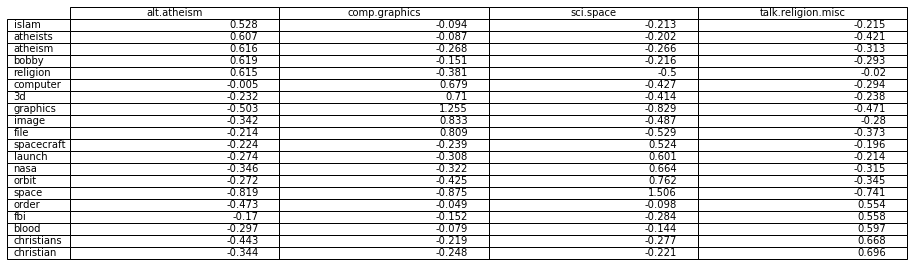

*****Let's print out 5 top features for each label in the case of unigram:*****
Top 5 features for Label - alt.atheism:
in this
is not
cheers kent
claim that
you are


Top 5 features for Label - comp.graphics:
comp graphics
is there
out there
looking for
in advance


Top 5 features for Label - sci.space:
it was
sci space
and such
the space
the moon


Top 5 features for Label - talk.religion.misc:
with you
the word
the fbi
cheers kent
but he


Now Print a weight table for 20 features and 4 labels in the case of bigram:


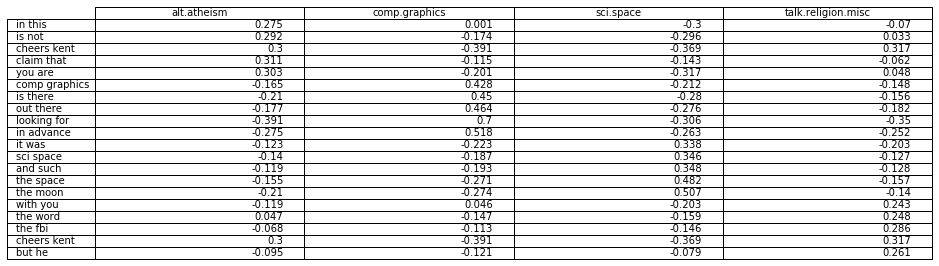

In [33]:
def P4():
### STUDENT START ###
    print "*"*5 + "Let's print out 5 top features for each label in the case of unigram:" + "*"*5
    # Initiate a count vector class
    cv=CountVectorizer()
    # Initiate an instance of LR classifier with the obtained optimal C
    clf=LogisticRegression(penalty='l2', C=0.20)
    # learn vocabulary from the train data
    X_train = cv.fit_transform(train_data)
    # Build LR classifier
    clf.fit(X_train, train_labels)
    
    # get feature names
    feature_names = cv.get_feature_names()
    
    # Extract indices of the five largest elements in each row of coef_
    ind = np.argpartition(clf.coef_, -5)[:,-5:]
    
    ## Print names of top 5 features for each label
    for i,j in enumerate(ind):
        print "Top 5 features for Label - %s:" %(newsgroups_train.target_names[i])
        for x in j:
            print(feature_names[x])
        print "\n"
    
    weight_table=np.take(clf.coef_, ind.flatten(), axis=1).T
    
    # Print table
    print "Now Print a weight table for 20 features and 4 labels in the case of bigram:"
    fig=plt.figure(figsize=(15, 1))
    ax = fig.add_subplot(111)
    ax.axis('off')
    the_table = ax.table(cellText=np.around(weight_table, decimals=3), colLabels = newsgroups_train.target_names, rowLabels = [feature_names[i] for i in ind.flatten()], loc='center')
    plt.show()
    
    # Create the table again with bigram features
    print "*"*5 + "Let's print out 5 top features for each label in the case of unigram:" + "*"*5
    #set classifier
    clf=LogisticRegression(penalty='l2', C=0.20)
    #set count vector
    cv=CountVectorizer(ngram_range=(2, 3))
    # learn vocabulary
    X = cv.fit_transform(train_data)
    # learn model
    clf.fit(X, train_labels)
    
    # get feature names
    feature_names = cv.get_feature_names()
    ##Find the 5 largest values in each row of coef_
    ind= np.argpartition(clf.coef_, -5)[:,-5:]
    
    ## Print top 5 features for each label
    for i,j in enumerate(ind):
        print("Top 5 features for Label - %s:" %(newsgroups_train.target_names[i]))
        for x in j:
            print(feature_names[x])
        print "\n"
        
    weight_table=np.take(clf.coef_, ind.flatten(), axis=1).T
    
    # Print table
    print "Now Print a weight table for 20 features and 4 labels in the case of bigram:"
    fig=plt.figure(figsize=(15, 1))
    
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.axis('off')
    the_table = plt.table(cellText=np.around(weight_table, decimals=3),rowLabels=[feature_names[i] for i in ind.flatten()], 
                           colLabels=newsgroups_train.target_names,loc='center')
    
    #ax = fig.add_subplot(111)
    #ax.axis('off')
    #names = newsgroups_train.target_names
    #colLabels=("feature", names[0], names[1], names[2], names[3])
    #the_table = ax.table(cellText=np.around(weight_table, decimals=3), colLabels = colLabels, rowLabels = [feature_names[i] for i in ind.flatten()], loc='center')
    #plt.show() 

### STUDENT END ###
P4()

ANSWER: 

As shown above, those top 5 features with largest weights for each label found by the Logistic Rregression classifier and unigram features are quite reasonable. For example, it is not surprising that words,  such as "space", "spacecraft", "launch", "nasa", "orbit", would show up frequently in "sci. space" related posts.  This is consistent with relatively the significant weights (e.g. > 0.5) observed for those top featurew in our study.  On the other hand, those top features for each label usually show much smaller (or negative)weights for other topics. However, when we switch to bigram features, except very few bingrams such as "the moon" and "the space", most selected bigram features like "it was" or "and such" are not intuitively related to the topic at all. Those bigrams associated with one topic may not show up in other unrelated topics at all; therefore, a lot of them won't be picked out by the LR model.  This results in a selection of a lot of less significant bigram features with small weights (usually between 0.2 and 0.55), such as "in this", "it was" or "and such", by Logistic Rregression model.  We may need to introduce a preprocessor to CountVectorizer to filter out some of those meaning features, such as "it was", "but he", "is there", etc.



(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [34]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    # Try lowercasing everything
    s = s.lower()
    # Remove non-letter or non-number characters
    s = re.sub("[^A-Za-z0-9 \n]", " ", s)
    # Now replacing sequences of numbers with a single token
    s = re.sub(r'[0-9]+', '1', s) # or s = re.sub('([\d]+)', "'1', s)
    # Shorten long words to no more than an arbitary 6-character
    s = re.sub("(\w{%d})\w+" % 6, "\\1", s)
    return s
### STUDENT END ###

def P5():
### STUDENT START ###
    # Define a function to use with both preprocessors
    def preprocessor_results(cv):
        #  Fit data and extract vocabulary vectors
        feature_vectors_train = cv.fit_transform(raw_documents=train_data)
        feature_vectors_dev = cv.transform(raw_documents=dev_data)
        
        # Initiate LR classifier instance, fit training data and predict on dev data
        Logit_model = LogisticRegression(penalty='l2', C= 0.20)
        Logit_model.fit(feature_vectors_train, train_labels)
        dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
        
        # Return the size of the dictionary for further comparison, as well as the F1 score
        return [feature_vectors_train.shape[1], metrics.f1_score(y_true=dev_labels,
                                                                 y_pred=dev_predicted_labels,
                                                                 average='macro')]
    # Call the preprocessor_results function for the empty preprocessor
    [size_empty, F1_empty] = preprocessor_results(CountVectorizer(preprocessor = empty_preprocessor))
    print 'F1 score for a Logistic Regression classifier using empty_preprocessor: %.3f' %F1_empty
    print 'The size of the dictionary with empty_preprocessor is: %d' %size_empty
    print '\n'
    # Call the preprocessor_results function for the better_preprocessor
    [size_better, F1_better] = preprocessor_results(CountVectorizer(preprocessor = better_preprocessor, \
                                                                                   stop_words='english'))
    print 'F1 score for a Logistic Regression classifier using better_preprocessor: %.3f' %F1_better
    print 'The size of the dictionary with better_preprocessor is: %d' %size_better
### STUDENT END ###
P5()

F1 score for a Logistic Regression classifier using empty_preprocessor: 0.685
The size of the dictionary with empty_preprocessor is: 33291


F1 score for a Logistic Regression classifier using better_preprocessor: 0.720
The size of the dictionary with better_preprocessor is: 17528


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

When C= 0.0005:
The number of nonzero weights from the LR model with the L1 penalty: 4
The size of vocabulary from the LR model with the L1 penalty: 1
The number of nonzero weights from the LR model with the L2 penalty: 107516
The size of vocabulary from the LR model with the L2 penalty: 26879
The number of nonzero weights of the trtrained LR model after feature pruning: 4
The accuracy of the re-trained LR model after feature pruning 0.3284


When C= 0.0010:
The number of nonzero weights from the LR model with the L1 penalty: 6
The size of vocabulary from the LR model with the L1 penalty: 3
The number of nonzero weights from the LR model with the L2 penalty: 107516
The size of vocabulary from the LR model with the L2 penalty: 26879
The number of nonzero weights of the trtrained LR model after feature pruning: 12
The accuracy of the re-trained LR model after feature pruning 0.3817


When C= 0.0050:
The number of nonzero weights from the LR model with the L1 penalty: 22
The size of vocab

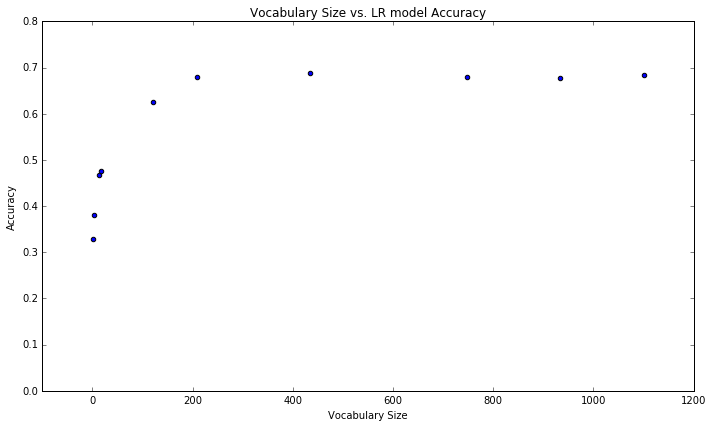

In [35]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    # Demonstrate the effectiveness of L1 nom for feature seleciton 
    # Train a LR model with "l1" norm and other default parameters as the example
    # Output the number of non-zero weights
    #clf_l1 = LogisticRegression(penalty='l1')
    #cv_l1 = CountVectorizer()
    #X_l1 = cv.fit_transform(train_data)
    #clf.fit(X_l1, train_labels)
    #coefs = clf.coef_

    # Print number of non-zero weights derived from L1
    #nnzL1 = len(np.nonzero(coefs)[1])
    #print("Number of non-zero learned weights for L1: %d" %(nnzL1))
    
    # Train a LR model with "l1" norm and other default parameters as the example
    # Output the number of non-zero weights
    #clf = LogisticRegression(penalty='l2')
    # cv = CountVectorizer()
    #X_L2 = cv.fit_transform(train_data)
    #clf.fit(X_L2, train_labels)
    #coefs = clf.coef_
    
    # Find number of non-zero weights derived from L2
    #nnzL2 =len(np.nonzero(coefs)[1])
    #print("Number of non-zero learned weights for L2: %d" %(nnzL2))
    #print("As shown above, L1 norm can siginficantly force the weights of a lot of trivial features into zero!")
    
    # Now let's do it in a more systematic way with differnt C values
    # Firt predefine a set of C values for this study
    C_values = np.array([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1])
    
    # Predefine arrays of accuracy, vocabulary sizes, weights to hold to outcomes 
    accuracy = np.zeros(len(C_values))
    vocab_size = np.zeros(len(C_values)).astype('u4')
    nonzero_weights = np.zeros(len(C_values)).astype('u4')
    
    # Print outcomes of differnt LR models with various C values
    for i in range(len(C_values)):
        # Initiate a CountVectorizer instance
        cv = CountVectorizer()
        feature_vectors_train = cv.fit_transform(raw_documents=train_data)
        feature_vectors_dev = cv.transform(raw_documents=dev_data)
        
        # Initate a LR regression instance with the "l1" penalty and relaxed tol of 0.01
        Logit_model_l1 = LogisticRegression(penalty='l1', C = C_values[i], tol=.01)
        Logit_model_l1.fit(feature_vectors_train, train_labels)
        # Get the number of non-zero weights from the LR model with l1 norm 
        nonzero_weights[i] = len(np.nonzero(Logit_model_l1.coef_)[1])
        # Obtain vocabulary size and number of nonzero weights
        vocab_size[i] = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0,
                                                             Logit_model_l1.coef_))
        # filter weights that are equal to zero.
        mask = (Logit_model_l1.coef_!=0)
        # Keep features with at least one non-zero weight for one class
        idx = mask.any(axis=0)
        # Prune both sparse matrices of train and dev sets
        feature_vectors_train_pruned = feature_vectors_train[:, idx]
        feature_vectors_dev_pruned = feature_vectors_dev[:, idx]

        print "When C= %.4f:" %C_values[i]
        print "The number of nonzero weights from the LR model with the L1 penalty: %d" %(nonzero_weights[i])
        print 'The size of vocabulary from the LR model with the L1 penalty: %d' %vocab_size[i]
        
        # Initate a LR regression instance with the "l2" penalty and relaxed tol of 0.01
        Logit_model_l2 = LogisticRegression(penalty='l2', C = C_values[i], tol=.01)
        Logit_model_l2.fit(feature_vectors_train, train_labels)
        # Get the number of non-zero weights from the LR model with l2 norm 
        nonzero_weights[i] = len(np.nonzero(Logit_model_l2.coef_)[1])
        # Obtain vocabulary size and number of nonzero weights
        vocab_size[i] = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0,
                                                             Logit_model_l2.coef_))
        print "The number of nonzero weights from the LR model with the L2 penalty: %d" %(nonzero_weights[i])
        print "The size of vocabulary from the LR model with the L2 penalty: %d" %vocab_size[i]
                    
        # Fit the LR regression instance with the pruned features 
        Logit_model_l2.fit(feature_vectors_train_pruned, train_labels)
        # Get the number of non-zero weights from the LR model with l2 norm 
        nonzero_weights[i] = len(np.nonzero(Logit_model_l2.coef_)[1])
        vocab_size[i] = np.count_nonzero(np.apply_along_axis(np.count_nonzero, 0, Logit_model_l2.coef_))
        print "The number of nonzero weights of the trtrained LR model after feature pruning: %d" %(nonzero_weights[i])
       
        dev_predicted_labels_pruned = Logit_model_l2.predict(feature_vectors_dev_pruned)
        accuracy[i] = metrics.accuracy_score(y_true=dev_labels,
                                             y_pred=dev_predicted_labels_pruned)
        print "The accuracy of the re-trained LR model after feature pruning %.4f" %accuracy[i]
        print "\n"
        
    # Plot the accuracy of the re-trained model vs. the vocabulary size after feature pruning 
    print "Plot the accuracy of the re-trained model vs. the vocabulary size after feature pruning:"
    plt.figure(figsize=(10, 6))
    plt.scatter(vocab_size, accuracy)
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Accuracy")
    plt.title('Vocabulary Size vs. LR model Accuracy')
    plt.xlim([-100, vocab_size.max()+100])
    plt.ylim([0, 0.8])
    plt.tight_layout()
    ### STUDENT END ###    
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [36]:
def P7():
    ### STUDENT START ###
    # Initiate a TfidfVectorizer instance
    tfidfv = TfidfVectorizer()
    # Extract vocabulary features from the training data and derive dev feature matrix
    train_features = tfidfv.fit_transform(train_data)
    dev_features = tfidfv.transform(dev_data)
    # Initiate a lR classifier instance and fit the training data
    lr = LogisticRegression(C=100)
    lr.fit(train_features, train_labels)

    # Predict dev labels and associated probility
    dev_predicted_labels = lr.predict(dev_features )
    dev_Probs = lr.predict_proba(dev_features)
    
    # maximum predicted probability for each dev data point
    max_Prob = dev_Probs.max(axis=1)
    # predicted probability of the correct label
    Prob_correct_label = np.array([dev_Probs[i,j] for i,j in
                                   zip(range(len(dev_labels)),dev_labels)])

    # R - maximum predicted probability/predicted probability of the correct label
    R_values = max_Prob / Prob_correct_label  
        
    # Find top 3 documents where the ratio R is largest,
    doc_index = np.argpartition(R_values, -3)[-3:]
    # Top 3 in descending order
    doc_index = doc_index[np.argsort(R_values[doc_index])][::-1]
    
    for i,ind in enumerate(doc_index):
        print '*'* 80
        print '{0}th DOCUMENT: R = {1:.2f}'.format(ind+1, R_values[ind])
        print '* PREDICTED CATEGORY (prob = {0:.4f}): {1}'.\
            format(max_Prob[ind],
                   newsgroups_train.target_names[dev_Probs[ind,:].argmax()])
        print '* CORRECT CATEGORY   (prob = {0:.4f}): {1}\n'.\
            format(dev_Probs[ind,dev_labels[ind]],
                   newsgroups_train.target_names[dev_labels[ind]])
        print '*'* 80
        
        print "Print out the document of dev data:"
        print dev_data[ind]
        print "\n\n"
    ### STUDENT END ###
P7()

********************************************************************************
216th DOCUMENT: R = 929.36
* PREDICTED CATEGORY (prob = 0.9937): comp.graphics
* CORRECT CATEGORY   (prob = 0.0011): talk.religion.misc

********************************************************************************
Print out the document of dev data:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people

ANSWER:
*******************************************************
#How is TfidfVectorizer different from CountVectorizer?
*******************************************************

In CountVectorizer, features are presented by counting the occurrence of the vocabularies while  TfidfVectorizer re-weights he count features into floating point values such that each row is normalized to have unit euclidean norm.  In this way, TfidfVectorizer produces smaller weights to meaningless words that presence in a lot of documents related to other topic as well.  

*******************************************************
#What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.
*******************************************************

First, I use the first selected case (226th document) shown above as the example.  This document should belong to   the topic of "talk.religion.misc", however, it is grouped as "comp.graphics" by the classifier.  That could be due to the simultaneous presence of multiple "comp.graphics" related keywords in this document, such as, "postscript", "RTF", "rich text format", "ASCII", "LaTeX", "Laserwriter", "printers" and "ftp" etc. Therefore, similar to the first case, it seems that some documents would be misclassified in this model as other topics if it also contains those keywords related to other topics.  The classifier would misclassify them due to the simple word counts or the binary features. 

Another case of misclassification can be illustrated by the 3rd selected example (608th document) here.  Since religion and atheism are very related topics, so it is not surprised that some of related documents are missclassified.

A potential solution could be overweigting those words 
By first running a regression with the L1 norm and picking a number of keywords only relavant to each specific topic and eliminate thosee misleading features.  And then we can train the regression model with reduced feature subsets and TfidfVectorizer transformation. 


(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

Accuracy for a Logistic Regression classifier using TfidfVectorizer: 75.89%
Percentage of incorrectly predicted labels (R>1): 24.11% (=1-Accuracy)

711.46   talk.religion.misc        comp.graphics 

139.82   talk.religion.misc        comp.graphics 

284.98          alt.atheism   talk.religion.misc 

--------------------------------------------------------
216th DOCUMENT: R = 711.46
* PREDICTED CATEGORY (prob = 0.9923): comp.graphics
* CORRECT CATEGORY   (prob = 0.0014): talk.religion.misc

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "

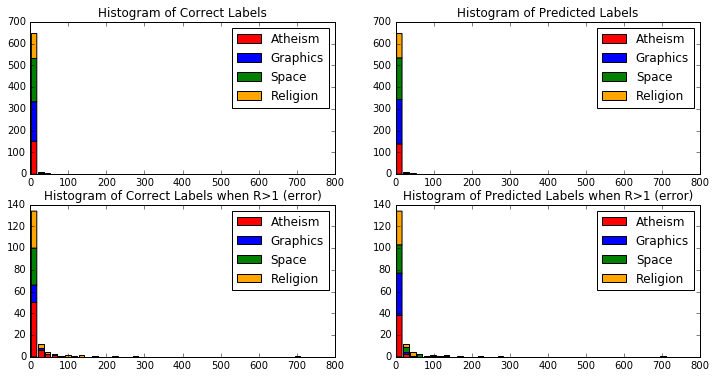

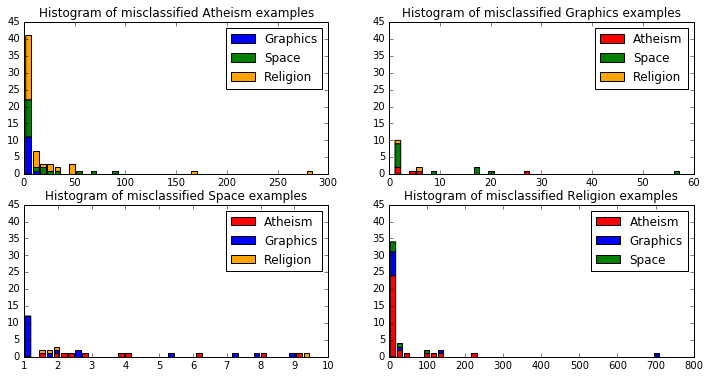

In [37]:
def P8():
### STUDENT START ###
    # Let's try adding some words common in "graphics" (but not exclusive of that topic) as stop_words
    TFIDF = TfidfVectorizer(stop_words=['ftp','site','internet','anonymous','microsoft','online','email','address'])
    feature_vectors_train = TFIDF.fit_transform(raw_documents=train_data)
    Logit_model = LogisticRegression(penalty='l2', C = 100)
    Logit_model.fit(feature_vectors_train, train_labels)
    feature_vectors_dev = TFIDF.transform(raw_documents=dev_data)
    dev_predicted_labels = Logit_model.predict(feature_vectors_dev)
    print 'Accuracy for a Logistic Regression classifier using TfidfVectorizer: {0:.2f}%'.\
        format(100*metrics.accuracy_score(y_true=dev_labels, y_pred=dev_predicted_labels))
    dev_Probs = Logit_model.predict_proba(feature_vectors_dev)
    # maximum predicted probability
    max_Prob = dev_Probs.max(axis=1)
    # predicted probability of the correct label
    Prob_correct_label = np.array([dev_Probs[i,j] for i,j in
                                   zip(range(len(dev_labels)),dev_labels)])
    # R = maximum predicted probability / predicted probability of the correct label
    R = max_Prob / Prob_correct_label
    print 'Percentage of incorrectly predicted labels (R>1): {0:.2f}% (=1-Accuracy)\n'.\
        format(100*len(R[R>1])/float(len(R)))
    # Results from previous Top 3
    for i in (215,665, 607):
        print R[i].round(2), newsgroups_train.target_names[dev_labels[i]].rjust(20),\
            newsgroups_train.target_names[dev_Probs[i,:].argmax()].rjust(20),'\n'
    # Top 3
    doc_index = np.argpartition(R, -3)[-3:]
    # Top 3 in descending order
    doc_index = doc_index[np.argsort(R[doc_index])][::-1]
    for i,ind in enumerate(doc_index):
        print '--------------------------------------------------------'
        print '{0}th DOCUMENT: R = {1:.2f}'.format(ind+1, R[ind])
        print '* PREDICTED CATEGORY (prob = {0:.4f}): {1}'.\
            format(max_Prob[ind],
                   newsgroups_train.target_names[dev_Probs[ind,:].argmax()])
        print '* CORRECT CATEGORY   (prob = {0:.4f}): {1}\n'.\
            format(dev_Probs[ind,dev_labels[ind]],
                   newsgroups_train.target_names[dev_labels[ind]])
        print dev_data[ind]
    
    # Plot histograms of labels (correct and predicted)
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    atheism = R[(dev_labels==0)]
    graphics = R[(dev_labels==1)]
    space = R[(dev_labels==2)]
    religion = R[(dev_labels==3)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels')
    ax = plt.subplot(2, 2, 2)
    pred_atheism = R[(dev_predicted_labels==0)]
    pred_graphics = R[(dev_predicted_labels==1)]
    pred_space = R[(dev_predicted_labels==2)]
    pred_religion = R[(dev_predicted_labels==3)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels')
    # The first two graphs (top row) show all the examples in the dev set
    # The first bar in both graphs show examples with R=1, i.e., correctly classified so the proportion of each
        # category is the same in both graphs (due to the bin width, some examples with an R ratio greater than 1
        # are also included in that first bar, so there may be some minor differences between both graphs)
    # To zoom in what really happens when R>1 (i.e., when the prediction is not correct) we plot (in the bottom row)
        # the histogram for R>1.
    ax = plt.subplot(2, 2, 3)
    atheism = R[(dev_labels==0) & (R>1)]
    graphics = R[(dev_labels==1) & (R>1)]
    space = R[(dev_labels==2) & (R>1)]
    religion = R[(dev_labels==3) & (R>1)]
    plt.hist([atheism,graphics,space,religion], 40, stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Correct Labels when R>1 (error)')
    ax = plt.subplot(2, 2, 4)
    pred_atheism = R[(dev_predicted_labels==0) & (R>1)]
    pred_graphics = R[(dev_predicted_labels==1) & (R>1)]
    pred_space = R[(dev_predicted_labels==2) & (R>1)]
    pred_religion = R[(dev_predicted_labels==3) & (R>1)]
    plt.hist([pred_atheism,pred_graphics,pred_space,pred_religion], 40,
             stacked=True, color=['red','blue','green','orange'])
    plt.legend(['Atheism','Graphics','Space','Religion'])
    plt.title('Histogram of Predicted Labels when R>1 (error)')
    # Roughly same results than before.
        
    # To see what are the most common mistakes, we now plot the proportion of misclassifications for each topic:
    atheism_graphics = R[(dev_labels==0) & (dev_predicted_labels==1)]
    atheism_space = R[(dev_labels==0) & (dev_predicted_labels==2)]
    atheism_religion = R[(dev_labels==0) & (dev_predicted_labels==3)]
    graphics_atheism = R[(dev_labels==1) & (dev_predicted_labels==0)]
    graphics_space = R[(dev_labels==1) & (dev_predicted_labels==2)]
    graphics_religion = R[(dev_labels==1) & (dev_predicted_labels==3)]
    space_atheism = R[(dev_labels==2) & (dev_predicted_labels==0)]
    space_graphics = R[(dev_labels==2) & (dev_predicted_labels==1)]
    space_religion = R[(dev_labels==2) & (dev_predicted_labels==3)]
    religion_atheism = R[(dev_labels==3) & (dev_predicted_labels==0)]
    religion_graphics = R[(dev_labels==3) & (dev_predicted_labels==1)]
    religion_space = R[(dev_labels==3) & (dev_predicted_labels==2)]
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(2, 2, 1)
    plt.hist([atheism_graphics,atheism_space,atheism_religion], 40, stacked=True, color=['blue','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Graphics','Space','Religion'])
    plt.title('Histogram of misclassified ''Atheism'' examples')
    ax = plt.subplot(2, 2, 2)
    plt.hist([graphics_atheism,graphics_space,graphics_religion], 40, stacked=True, color=['red','green','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Space','Religion'])
    plt.title('Histogram of misclassified ''Graphics'' examples')
    ax = plt.subplot(2, 2, 3)
    plt.hist([space_atheism,space_graphics,space_religion], 40, stacked=True, color=['red','blue','orange'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Religion'])
    plt.title('Histogram of misclassified ''Space'' examples')
    ax = plt.subplot(2, 2, 4)
    plt.hist([religion_atheism,religion_graphics,religion_space], 40, stacked=True, color=['red','blue','green'])
    plt.ylim([0, 45])
    plt.legend(['Atheism','Graphics','Space'])
    plt.title('Histogram of misclassified ''Religion'' examples')
    # Roughly same results than before.
### STUDENT END ###
P8()